In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from modules.benchmarks import MultiPeriodMeanVariance
import matplotlib.pyplot as plt
import quantstats as qs
import json

In [2]:
config_file_name = "config.json"
with open(config_file_name, "r") as jsonfile:
    config_data = json.load(jsonfile)

In [3]:
sp100 = config_data["tickers"]["America"]["SP100"]
NUM_ASSETS = len(sp100)
len(sp100)

101

In [4]:
start_date = config_data["timeframe"]["sp100"]["start_date"]
end_date = config_data["timeframe"]["sp100"]["end_date"]
data_interval = config_data["data_interval"]
test_ratio = config_data["train_test_ratio"]
random_seed = config_data["random_state_seed"]

In [5]:
dataset = yf.download(sp100, 
                      start=start_date, 
                      end=end_date,
                      interval=data_interval)['Adj Close']
dataset.to_csv("data/raw/sp100_stocks_price.csv")

[*********************100%%**********************]  101 of 101 completed


In [6]:
dataset_price_change = dataset.pct_change().fillna(0)
dataset_return = dataset/dataset.shift(1).fillna(1)

In [7]:
NUM_ASSETS = len(dataset.columns.unique().tolist())

In [8]:
lookback_window = config_data["lookback_window"] # W
multi_step_horizon = config_data["multi_step_horizon"] # T
lookback_window, multi_step_horizon

(24, 3)

In [9]:
X_test_mpo = []
for i in range(len(dataset_price_change.values)-lookback_window):
    Sigmas = []
    mu = []
    for j in range(multi_step_horizon):
        cov_matrix_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].cov().values
        mu_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = dataset_return.iloc[i:i+lookback_window]
    pred = dataset_return.iloc[i+lookback_window:i+lookback_window+multi_step_horizon]
    X_test_mpo.append([hist, np.stack(mu), np.stack(Sigmas), pred])

len(X_test_mpo)

101

In [10]:
X_test_spo = []
for i in range(len(dataset_price_change.values)-lookback_window):
    Sigmas = []
    mu = []
    for j in range(1):
        cov_matrix_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].cov().values
        mu_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = dataset_return.iloc[i:i+lookback_window]
    pred = dataset_return.iloc[i+lookback_window:i+lookback_window+multi_step_horizon]
    X_test_spo.append([hist, np.stack(mu), np.stack(Sigmas), pred])

len(X_test_spo)

101

Markowitz's Multi-Period Optimization

In [11]:
mean_variance_mpo = MultiPeriodMeanVariance(
    num_assets=NUM_ASSETS,
    multi_period_step=multi_step_horizon,
    min_individual_allocation=0.005,
    max_individual_allocation=0.25,
    risk_aversion_coefficient=1,
    trade_cost=0.0025,
    holding_cost=0
)

Markowitz's Single Period Optimization

In [12]:
mean_variance_spo = MultiPeriodMeanVariance(
    num_assets=NUM_ASSETS,
    multi_period_step=1,
    min_individual_allocation=0.005,
    max_individual_allocation=0.25,
    risk_aversion_coefficient=1,
    trade_cost=0.0025,
    holding_cost=0
)

In [13]:
result_mv_mpo = []
for hist, mu, Sigma, pred in X_test_mpo:
   if len(pred) < multi_step_horizon:
      continue
   mpo_opt_weights = mean_variance_mpo(mu, Sigma)
   portfolio_value_mpo = (mpo_opt_weights*pred).sum(1).prod()
   result_mv_mpo.append(portfolio_value_mpo)

In [14]:
result_mv_spo = []
for hist, mu, Sigma, pred in X_test_spo:
   spo_opt_weights = mean_variance_spo(mu, Sigma)
   portfolio_value_spo = (spo_opt_weights*pred).sum(1).prod()
   result_mv_spo.append(portfolio_value_spo)

In [15]:
result_mv_spo = result_mv_spo[:len(result_mv_mpo)]
len(result_mv_spo), len(result_mv_mpo)

(99, 99)

In [16]:
result_mv_mpo = pd.Series(result_mv_mpo, index=dataset[-len(result_mv_mpo):].index)
result_mv_mpo = result_mv_mpo.pct_change().fillna(0).cumsum()
len(result_mv_mpo)

99

In [17]:
result_mv_spo = pd.Series(result_mv_spo, index=dataset[-len(result_mv_spo):].index)
result_mv_spo = result_mv_spo.pct_change().fillna(0).cumsum()
len(result_mv_spo)

99

In [18]:
result_mv_mpo_plot = result_mv_mpo*100
result_mv_spo_plot = result_mv_spo*100

In [19]:
sp100_etf_ticker = "^OEX"
sp100_index = yf.download(sp100_etf_ticker, 
                        start=start_date, 
                        end=end_date,
                        interval=data_interval)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [20]:
sp100_index = sp100_index.loc[result_mv_mpo.index]
sp100_index = sp100_index.pct_change().fillna(0)
sp100_index = sp100_index.cumsum()
sp100_index_plot = sp100_index*100

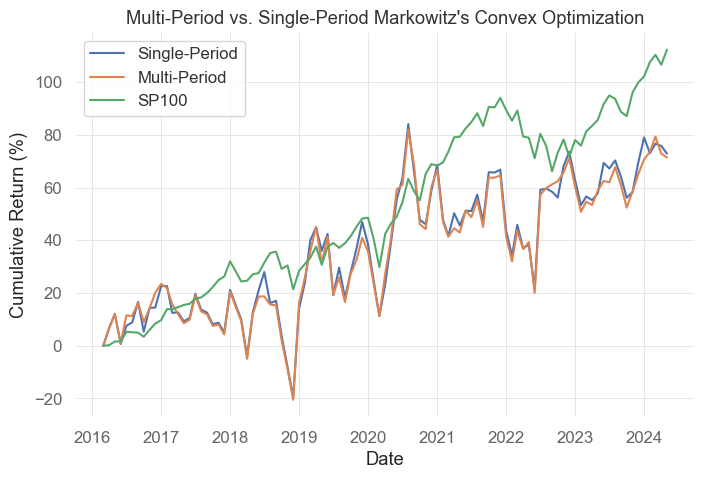

In [35]:
plt.figure(figsize=(8,5))
plt.plot(result_mv_spo_plot.index, result_mv_spo_plot, label='Single-Period')
plt.plot(result_mv_mpo_plot.index, result_mv_mpo_plot, label='Multi-Period')
plt.plot(sp100_index_plot.index, sp100_index_plot, label='SP100')
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.title("Multi-Period vs. Single-Period Markowitz's Convex Optimization")
plt.show()

In [26]:
def fapv(x):
    return x.iloc[-1]/x.iloc[0]

Persisting the data in data/processed file

In [30]:
performances_result_df = pd.concat([result_mv_mpo, result_mv_spo, sp100_index], axis=1)
performances_result_df.columns = ["MPO", "SPO", "SP100"]
performances_result_df += 1
performances_result_df.head()

,MPO,SPO,SP100
Date,,,
2016-03-01,1.000000,1.000000,1.000000
2016-04-01,1.067263,1.067353,1.002289
2016-05-01,1.121838,1.119996,1.016092
2016-06-01,1.009459,1.006882,1.016610
2016-07-01,1.114940,1.075758,1.052833


In [31]:
# 1. final Accumulated Portfolio Value
fapv_mpo = performances_result_df.apply(lambda x: fapv(x), axis=0)
# 2. Sharpe Ratio:
sr_mpo = performances_result_df.apply(lambda x: qs.stats.sharpe(x, periods=12, annualize=True), axis=0)
# 3. Maximum DrawDown:
mdd_mpo = performances_result_df.apply(lambda x: qs.stats.max_drawdown(x), axis=0)

MPO vs. SPO Metrics

In [32]:
metrics_df_sp100 = pd.concat([fapv_mpo, sr_mpo, mdd_mpo], axis=1)
metrics_df_sp100.columns = ["fAPV", "SR", "MDD"]
metrics_df_sp100 = metrics_df_sp100.T
metrics_df_sp100

,MPO,SPO,SP100
fAPV,1.714602,1.729492,2.123633
SR,0.353027,0.358771,0.942288
MDD,-0.356126,-0.371382,-0.143636


In [33]:
performances_result_df.to_csv("data/processed/performances_mpo_vs_spo.csv")